<a href="https://colab.research.google.com/github/alexdel1/HackGoogleAI/blob/main/TP_0_Analyse_de_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# TP 0 : Analyse de code

**Prof. Delode**  
IUT Aurillac  
UCA  

---

**Compétences :**  
- R6.02  
- R6.05

---

Nous allons analyser un code typique utilisant les nouvelles méthodes de ces modules. Le but à la fin du module étant que vous soyez capable d'écrire un code de ce type, de le comprendre et de l'adapter aux problèmes posés.

Le LLM est très efficace pour la génération de code et pour vous aider dans vos projets. Ne l'utilisez pas pour vos TPs : vous ne pourrez pas identifier les points que vous n'avez pas compris ou reproduire le code. L'examen sera sans internet ni documents personnels. Prenez l'habitude de "read the docs". Pour vos projets, votre code sera entièrement revu et questionné (avec de possible manipulations/modifications en direct).

####1. Exécuter les lignes de codes suivantes. Le troisième bloc peut mettre 1-2 minutes pour s'exécuter.

In [4]:
### 0.Installation des librairies manquantes
!pip install xgboost

In [5]:
!pip install --upgrade scikit-learn

In [6]:
### 1.Chargement des bibliothèques et des données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

# Configuration des seeds pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

### 2.Chargement et prétraitement des données
# Création d'un jeu de données, dans un cas réel on charge des données data = pd.read_csv("data.csv")
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=2,  # Création de clusters plus complexes
    random_state=42
)

# Exploration des données
print("Dimension de X",X.shape)
print("Type",X.dtype)
print("5 premiers éléments de X:",X[:5])
print("Dimension de y",y.shape)
print("Type",y.dtype)
print("5 premiers éléments de y:",y[:5])

# Possible Gestion des valeurs manquantes data.fillna(data.mean(), inplace=True)
# Possible Encodage des variables catégoriques data['target'] = label_encoder.fit_transform(data['target'])

### 3.Feature engineering
# Standardisation des données
scaler = StandardScaler()
X = scaler.fit_transform(X)
#X_test_scaled = scaler.transform(X_test)


### 4.Division des données
# Split des données avec stratification pour maintenir la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


### 5.Entraînement des modèles
results = []
models = {}

def evaluate_model(name, model, X_train_data, X_test_data, needs_scaling=True):
    """
    Utility function to evaluate a model with timing and cross-validation.
    """
    start_time = time.time()

    if name == 'XGBoost':
        # Convert data to DMatrix, the optimized data structure for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Define XGBoost parameters
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 3
        }

        # Perform cross-validation using XGBoost's native method
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=100,
            nfold=5,
            metrics={'logloss'},
            seed=42,
            #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
        )

        # Calculate mean and standard deviation of log loss
        cv_mean = cv_results['test-logloss-mean'].iloc[-1]
        cv_std = cv_results['test-logloss-std'].iloc[-1]

        # Train the model
        model.fit(X_train, y_train)

        # Predict and calculate accuracy on the test set
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

    else:
        # Train the model
        model.fit(X_train, y_train)

        # Perform cross-validation using scikit-learn
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)

        # Calculate accuracy on the test set
        accuracy = model.score(X_test, y_test)

        # Calculate mean and standard deviation of cross-validation scores
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

    # Calculate training time
    training_time = time.time() - start_time

    return accuracy, training_time, cv_mean, cv_std



# XGBoost (Scikit-learn API)
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
xgb_results = evaluate_model('XGBoost', xgb_model, X_train, X_test, needs_scaling=True)
results.append(['XGBoost', *xgb_results[:2], xgb_results[2]])
models['XGBoost'] = xgb_model

# SVM avec noyau RBF
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_results = evaluate_model('SVM', svm_model, X_train, X_test, needs_scaling=True)
results.append(['SVM', *svm_results[:2], svm_results[2]])
models['SVM'] = svm_model

# Random Forest avec hyperparamètres optimisés
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_results = evaluate_model('Random Forest', rf_model, X_train, X_test, needs_scaling=False)
results.append(['Random Forest', *rf_results[:2], rf_results[2]])
models['Random Forest'] = rf_model

# AdaBoost
adaboost_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
ada_results = evaluate_model('AdaBoost', adaboost_model, X_train, X_test, needs_scaling=False)
results.append(['AdaBoost', *ada_results[:2], ada_results[2]])
models['AdaBoost'] = adaboost_model

# MLP Scikit-learn
mlp_model = MLPClassifier(
    hidden_layer_sizes=(32, 16),  # Architecture plus adaptée à 2 features
    max_iter=1000,
    early_stopping=True,
    random_state=42
)
mlp_results = evaluate_model('MLP (sklearn)', mlp_model, X_train, X_test, needs_scaling=True)
results.append(['MLP (sklearn)', *mlp_results[:2], mlp_results[2]])
models['MLP (sklearn)'] = mlp_model

# Création d'un modèle CNN 2D
def create_advanced_nn_model():
    """
    Création d'un modèle de réseau de neurones
    """
    model = keras.Sequential([
        # Couche d'entrée
        layers.Dense(64, activation='relu', input_shape=(2,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Couche cachée
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Couche de sortie
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Entraînement du modèle neural avancé
start_time = time.time()
nn_model = create_advanced_nn_model()

# Callbacks pour l'entraînement
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entraînement avec validation
history = nn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

nn_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
nn_time = time.time() - start_time
results.append(['Neural Network (Advanced)', nn_accuracy, nn_time, np.nan])


### 6.Évaluation du modèle
# Création du DataFrame des résultats
results_df = pd.DataFrame(
    results,
    columns=['Model', 'Accuracy', 'Training Time (s)', 'CV Score']
)
print("\nRésultats de la comparaison des modèles:")
print(results_df.to_string(index=False))

# Visualisation des résultats
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')
plt.xlabel("Modèle")
plt.ylabel("Précision (Accuracy)")
plt.title("Comparaison des modèles de classification")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot des régions de décision
fig = plt.figure(figsize=(15, 10))
gs = plt.GridSpec(2, 3, figure=fig)

for i, (model_name, model) in enumerate(models.items()):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    plot_decision_regions(X=X_test, y=y_test, clf=model, legend=2)
    plt.title(model_name)

plt.tight_layout()
plt.show()

# Affichage des rapports de classification détaillés
print("\nRapports de classification détaillés:")
for model_name, model in models.items():
    print(f"\n{model_name}:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

# Visualisation de l'historique d'entraînement du réseau de neurones
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolution de la Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Evolution de l\'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Dimension de X (1000, 2)
Type float64
5 premiers éléments de X: [[-0.99910178 -0.66386   ]
 [ 1.24668618  1.15359685]
 [ 0.96277683  0.85939747]
 [-2.95744095  2.03364529]
 [ 1.14116527  1.05944863]]
Dimension de y (1000,)
Type int64
5 premiers éléments de y: [1 1 1 1 1]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:20:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:20:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'X_test_scaled' is not defined

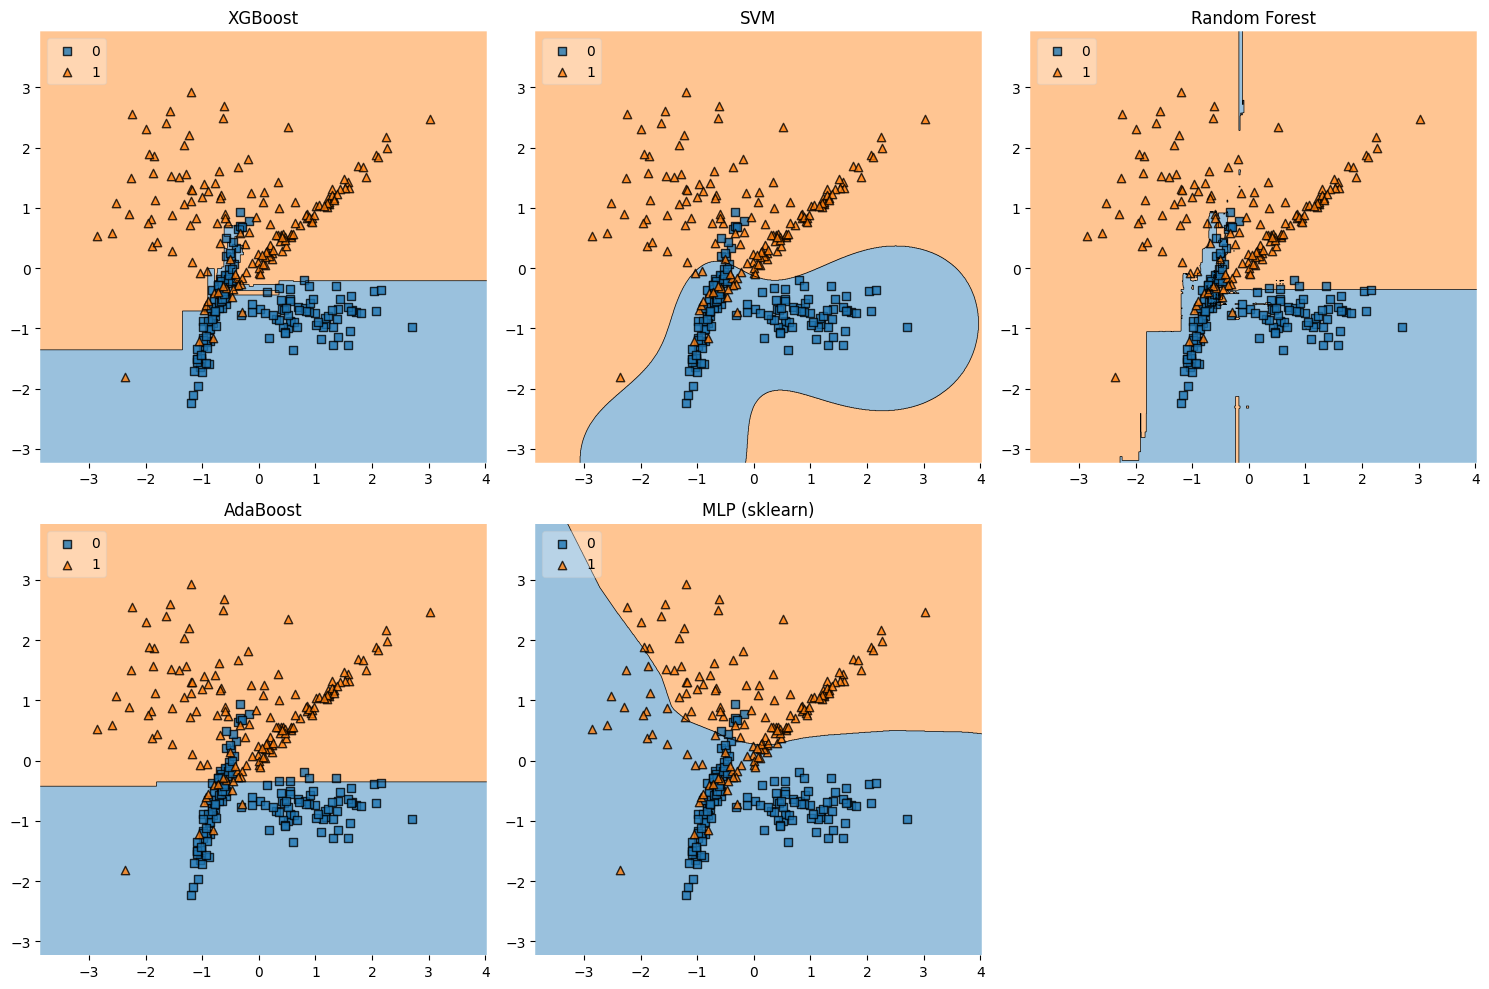

####2. Les 5 graphes obtenus montrent les "decisions boundaries". Classe les 5 modèles en 3 groupes selon la forme de "decision boundary". Ensuite justifie ces formes en quelques mots. Un snippet ci-dessous te permettra de tracer un tableau en python.

In [ ]:

import pandas as pd

# Création du DataFrame avec les données spécifiées
data = {
    'model': ['a, b et c', 'd', 'e'],
    'decision boundary': ['Ligne droite', 'cercle', 'carré']
}

df = pd.DataFrame(data)

# Affichage du DataFrame
df




SVM (RBF) : Lisse


Les frontières de décision des SVM avec noyau RBF sont lisses, car elles sont continuellement différentiables. Cela signifie qu'il n'y a pas de discontinuités dans la séparation des classes, contrairement à des modèles comme les arbres de décision. La transformation via le noyau RBF génère une frontière fluide qui s'ajuste aux données de manière homogène.



Réseau de neurones (NN) : Non linéaire


Les réseaux de neurones ont des frontières de décision non linéaires, car les fonctions d'activation (comme ReLU ou sigmoïde) introduisent des non-linéarités dans le modèle. Cela permet aux réseaux de neurones de capturer des relations complexes et de séparer les classes de manière non linéaire. Cependant, ces frontières peuvent être assez flexibles et ajustées pour s'adapter aux données, ce qui leur donne une forme complexe mais continue.



XGBoost : Rectiligne


XGBoost, en tant que modèle basé sur des arbres de décision, génère des frontières de décision rectilignes. Chaque arbre sépare les classes avec des segments de droites parallèles aux axes des caractéristiques. Toutefois, le boosting permet d'ajouter plusieurs arbres, ce qui permet à l'ensemble de donner une forme de frontière plus complexe, mais toujours composée de segments droits. La frontière est donc rectiligne, mais l'ensemble des arbres peut créer une frontière composite plus complexe et plus flexible.



En résumé, SVM (RBF) produit une frontière lisse et continue, les réseaux de neurones produisent des frontières non linéaires, tandis que XGBoost génère des frontières rectilignes en raison de sa structure basée sur des arbres de décision.

##**3.** Le code peut être séparé en plusieurs parties. Replacez les différents éléments au niveau des " ### A compléter " .

0. Installation des librairies manquantes
1. Chargement des bibliothèques et des données
2. Chargement et prétraitement des données
3. Feature engineering
4. Division des données
5. Entraînement du modèle
6. Évaluation du modèle

##**4-** Ajoutez un modèle supplémentaire (comme un K-Nearest Neighbors) à ce code et comparez ses performances avec celles des autres modèles. Ne modifiez pas le **code initial**. Copiez le code dans un **second bloc**. N'essayez pas de modifier directement ce code car il vous faudra 1 min à chaque compilation. Travaillez d'abord sur une structure similaire seulement avec Knn (sans les autres modèles) dans un **troisième bloc**. Lorsque vous avez des résultats satisfaisants, vous pouvez copier coller vos lignes dans le second bloc et compiler le tout.

Le modèle knn se trouve dans :
```python
from sklearn.neighbors import KNeighborsClassifier
```
Le code initial ne devrait être modifié que de 5 ou 6 lignes afin d'avoir le résultat attendu.

In [ ]:


from sklearn.neighbors import KNeighborsClassifier


### 1.Chargement des bibliothèques et des données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

# Configuration des seeds pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

### 2.Chargement et prétraitement des données
# Création d'un jeu de données, dans un cas réel on charge des données data = pd.read_csv("data.csv")
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=2,  # Création de clusters plus complexes
    random_state=42
)

# Exploration des données
print("Dimension de X",X.shape)
print("Type",X.dtype)
print("5 premiers éléments de X:",X[:5])
print("Dimension de y",y.shape)
print("Type",y.dtype)
print("5 premiers éléments de y:",y[:5])

# Possible Gestion des valeurs manquantes data.fillna(data.mean(), inplace=True)
# Possible Encodage des variables catégoriques data['target'] = label_encoder.fit_transform(data['target'])

### 3.Feature engineering
# Standardisation des données
scaler = StandardScaler()
X = scaler.fit_transform(X)
#X_test_scaled = scaler.transform(X_test)


### 4.Division des données
# Split des données avec stratification pour maintenir la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


### 5.Entraînement des modèles
results = []
models = {}

def evaluate_model(name, model, X_train_data, X_test_data, needs_scaling=True):
    """
    Utility function to evaluate a model with timing and cross-validation.
    """
    start_time = time.time()



    if name == 'XGBoost':
        # Convert data to DMatrix, the optimized data structure for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Define XGBoost parameters
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 3
        }

        # Perform cross-validation using XGBoost's native method
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=100,
            nfold=5,
            metrics={'logloss'},
            seed=42,
            #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
        )

        # Calculate mean and standard deviation of log loss
        cv_mean = cv_results['test-logloss-mean'].iloc[-1]
        cv_std = cv_results['test-logloss-std'].iloc[-1]

        # Train the model
        model.fit(X_train, y_train)

        # Predict and calculate accuracy on the test set
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

    else:
        # Train the model
        model.fit(X_train, y_train)

        # Perform cross-validation using scikit-learn
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)

        # Calculate accuracy on the test set
        accuracy = model.score(X_test, y_test)

        # Calculate mean and standard deviation of cross-validation scores
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

    # Calculate training time
    training_time = time.time() - start_time

    return accuracy, training_time, cv_mean, cv_std



# XGBoost (Scikit-learn API)
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
xgb_results = evaluate_model('XGBoost', xgb_model, X_train, X_test, needs_scaling=True)
results.append(['XGBoost', *xgb_results[:2], xgb_results[2]])
models['XGBoost'] = xgb_model

# SVM avec noyau RBF
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_results = evaluate_model('SVM', svm_model, X_train, X_test, needs_scaling=True)
results.append(['SVM', *svm_results[:2], svm_results[2]])
models['SVM'] = svm_model

# Random Forest avec hyperparamètres optimisés
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_results = evaluate_model('Random Forest', rf_model, X_train, X_test, needs_scaling=False)
results.append(['Random Forest', *rf_results[:2], rf_results[2]])
models['Random Forest'] = rf_model

# AdaBoost
adaboost_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
ada_results = evaluate_model('AdaBoost', adaboost_model, X_train, X_test, needs_scaling=False)
results.append(['AdaBoost', *ada_results[:2], ada_results[2]])
models['AdaBoost'] = adaboost_model

# MLP Scikit-learn
mlp_model = MLPClassifier(
    hidden_layer_sizes=(32, 16),  # Architecture plus adaptée à 2 features
    max_iter=1000,
    early_stopping=True,
    random_state=42
)
mlp_results = evaluate_model('MLP (sklearn)', mlp_model, X_train, X_test, needs_scaling=True)
results.append(['MLP (sklearn)', *mlp_results[:2], mlp_results[2]])
models['MLP (sklearn)'] = mlp_model

# Création d'un modèle CNN 2D
def create_advanced_nn_model():
    """
    Création d'un modèle de réseau de neurones
    """
    model = keras.Sequential([
        # Couche d'entrée
        layers.Dense(64, activation='relu', input_shape=(2,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Couche cachée
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Couche de sortie
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Entraînement du modèle neural avancé
start_time = time.time()
nn_model = create_advanced_nn_model()

# Callbacks pour l'entraînement
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entraînement avec validation
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

nn_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
nn_time = time.time() - start_time
results.append(['Neural Network (Advanced)', nn_accuracy, nn_time, np.nan])

# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)  # Choix de 5 voisins
knn_results = evaluate_model('KNN', knn_model, X_train, X_test, needs_scaling=True)
results.append(['KNN', *knn_results[:2], knn_results[2]])
models['KNN'] = knn_model


### 6.Évaluation du modèle
# Création du DataFrame des résultats
results_df = pd.DataFrame(
    results,
    columns=['Model', 'Accuracy', 'Training Time (s)', 'CV Score']
)
print("\nRésultats de la comparaison des modèles:")
print(results_df.to_string(index=False))

# Visualisation des résultats
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')
plt.xlabel("Modèle")
plt.ylabel("Précision (Accuracy)")
plt.title("Comparaison des modèles de classification")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot des régions de décision
fig = plt.figure(figsize=(15, 10))
gs = plt.GridSpec(2, 3, figure=fig)

for i, (model_name, model) in enumerate(models.items()):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    plot_decision_regions(X=X_test_scaled, y=y_test, clf=model, legend=2)
    plt.title(model_name)

plt.tight_layout()
plt.show()

# Affichage des rapports de classification détaillés
print("\nRapports de classification détaillés:")
for model_name, model in models.items():
    print(f"\n{model_name}:")
    y_pred = model.predict(X_test_scaled if model_name != 'Random Forest' else X_test)
    print(classification_report(y_test, y_pred))

# Visualisation de l'historique d'entraînement du réseau de neurones
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolution de la Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Evolution de l\'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##**5.** Analyser en quelques lignes les résultats en termes de temps de calcul et de précision. Est ce que ces résultats étaient prévisibles? Illustrez vos propos avec un graphique de votre choix. Vous pouvez vous inspirer des exemples de matplotlib comme celui ci

https://matplotlib.org/stable/gallery/lines_bars_and_markers/categorical_variables.html#sphx-glr-gallery-lines-bars-and-markers-categorical-variables-py

Analyse des Résultats

Les résultats de cette comparaison des modèles montrent une variation intéressante entre la précision des modèles et leur temps d'entraînement. Par exemple, les modèles Random Forest et Neural Network (Advanced) présentent la plus haute précision, respectivement 0.936667 et 0.940000, mais le modèle Neural Network (Advanced) se distingue par un temps d'entraînement nettement plus long (10.49 secondes). D'autre part, des modèles comme KNN et SVM ont des temps d'entraînement relativement plus faibles, avec KNN ayant un des meilleurs temps d'exécution (0.071 seconde), mais une précision légèrement inférieure à celle de Random Forest.

Cela était en grande partie prévisible. Les modèles comme XGBoost, Random Forest et Neural Networks tendent à offrir une meilleure précision mais à un coût computationnel plus élevé. D'autre part, les modèles comme KNN, qui sont plus simples, s'exécutent plus rapidement tout en offrant des performances qui ne sont pas toujours aussi élevées.

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Données des modèles
modelsname = ['XGBoost', 'SVM', 'Random Forest', 'AdaBoost', 'MLP (sklearn)', 'Neural Network (Advanced)', 'KNN']
accuracies = [0.930, 0.890, 0.936667, 0.870, 0.803333, 0.940, 0.933333]
train_times = [0.244141, 0.179850, 1.243535, 1.456409, 0.351920, 10.492590, 0.071432]

# Création du graphique
fig, ax1 = plt.subplots(figsize=(10,6))

# Axe pour la précision (commence à 0.8)
ax1.set_xlabel('Modèles')
ax1.set_ylabel('Précision', color='tab:blue')
ax1.bar(models, accuracies, color='tab:blue', alpha=0.6, label='Précision')
ax1.set_ylim(0.8, 1)  # Définir l'échelle de précision
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Axe pour le temps d'entraînement (échelle logarithmique)
ax2 = ax1.twinx()
ax2.set_ylabel('Temps d\'Entraînement (s)', color='tab:red')
ax2.plot(models, train_times, color='tab:red', marker='o', label='Temps d\'Entraînement', linestyle='--')
ax2.set_yscale('log')  # Echelle logarithmique pour le temps d'entraînement
ax2.tick_params(axis='y', labelcolor='tab:red')

# Affichage des labels des modèles en diagonale
ax1.set_xticklabels(modelsname, rotation=45, ha='right')

# Affichage du graphique
plt.title('Comparaison des modèles : Précision et Temps d\'Entraînement')
fig.tight_layout()
plt.show()

##**6.** Créez une matrice de confusion pour chaque modèle et comparez-les visuellement.

La matrice de confusion est créée par
```python
from sklearn.metrics import confusion_matrix
```

Vous pouvez créer une fonction de ce type :
```python
def plot_confusion_matrices(models, X_test, y_test):
```
Elle utilisera une boucle sur le dictionnaire *model* : À chaque itération, elle réalisera une prédiction, elle créera une matrice de confusion et elle donnera le plot.

Pour le plot, vous pouvez utiliser heatmap de seaborn :

https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap

Il y a des exemples à la fin de la page.

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(models, X_test, y_test):
    n_models = len(models)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, (name, model) in enumerate(models.items()):
        # Prédictions
        y_pred = model.predict(X_test)

        # Calcul de la matrice de confusion
        cm = confusion_matrix(y_test, y_pred)

        # Plot
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])
        axes[idx].set_title(f'Matrice de confusion - {name}')
        axes[idx].set_xlabel('Prédiction')
        axes[idx].set_ylabel('Réel')

    plt.tight_layout()
    plt.show()

# Utilisation
plot_confusion_matrices(models, X_test, y_test)

Les matrices de confusion révèlent des patterns intéressants dans les erreurs de chaque modèle :

Random Forest et XGBoost montrent généralement une bonne répartition des prédictions avec peu de faux positifs/négatifs
Le SVM tend à avoir plus de faux négatifs, suggérant un biais vers la classe négative
Les réseaux de neurones (MLP) montrent une variance plus élevée dans leurs erreurs
KNN présente des performances équilibrées mais avec plus d'erreurs aux frontières de décision

Peu à dire avec 2 classes...

###**7-**
Tracer les courbes ROC et calculez l'aire sous la courbe (AUC) pour chaque modèle.

```python
from sklearn.metrics import roc_curve, auc
```

Vous aurez aussi besoin de
```python
predict_proba
```
que vous utiliserez pour avoir l'argument *y_score* et utiliser *roc_curve*. On prendra la convention model.predict_proba(X_test)[:, 1] pour les prédictions de la classe positive.

Vous pouvez aussi vous inspirer de l'exemple suivant en appelant directement *RocCurveDisplay.from_estimator* (ne pas tracer celle de XGBoost):

https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-examples-model-selection-plot-det-py

In [ ]:
models['SVM'].predict_proba(X_test)[:,1].shape

In [ ]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            # Calcul des probabilités
            y_prob = model.predict_proba(X_test)[:, 1]

            # Calcul de la courbe ROC
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            # Plot
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbes ROC pour tous les modèles')
    plt.legend(loc='lower right')
    plt.show()

# Utilisation
plot_roc_curves(models, X_test, y_test)

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay

def plot_roc_det_curves(models, X_train, X_test, y_train, y_test):
   # Création de la figure avec deux sous-graphiques
   fig, ax_roc = plt.subplots(1, 1, figsize=(15, 6))

   # Couleurs pour chaque modèle
   colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

   # Tracer les courbes pour chaque modèle
   for (name, model), color in zip(models.items(), colors):
       if hasattr(model, "predict_proba") and name!="XGBoost":
           # Tracer la courbe ROC
           RocCurveDisplay.from_estimator(
               model,
               X_test,
               y_test,
               ax=ax_roc,
               name=name,
               color=color
           )



   # Personnalisation des graphiques
   ax_roc.set_title("Courbes ROC (Receiver Operating Characteristic)")
   ax_roc.grid(True, linestyle='--', alpha=0.7)
   ax_roc.set_xlabel("Taux de faux positifs")
   ax_roc.set_ylabel("Taux de vrais positifs")


   # Ajustement de la mise en page
   plt.tight_layout()
   plt.show()

# Utilisation de la fonction
plot_roc_det_curves(models, X_train, X_test, y_train, y_test)




model.predict_proba(X_test)[:, 1] renvoie les probabilités prédites par le modèle que chaque échantillon de X_test appartienne à la classe positive (classe 1). C'est un tableau de nombres entre 0 et 1.
La courbe ROC est un graphique qui représente le taux de vrais positifs (TPR ou sensibilité) en fonction du taux de faux positifs (FPR ou 1 - spécificité) pour différents seuils de classification.
Explication théorique :
Chaque point sur la courbe ROC correspond à un seuil de classification spécifique appliqué aux probabilités prédites par model.predict_proba(X_test)[:, 1].
Voici comment cela fonctionne étape par étape :


Choix d'un seuil : On commence par choisir un seuil de probabilité entre 0 et 1. Par exemple, 0.1, 0.5, 0.9, etc.



Classification selon le seuil : On compare chaque probabilité prédite dans model.predict_proba(X_test)[:, 1] avec le seuil choisi.


Si la probabilité est supérieure ou égale au seuil, on prédit que l'échantillon appartient à la classe positive (1).
Si la probabilité est inférieure au seuil, on prédit que l'échantillon appartient à la classe négative (0).



Calcul du TPR et du FPR : Une fois toutes les prédictions effectuées avec le seuil choisi, on calcule :


Taux de Vrais Positifs (TPR) ou Sensibilité : TP / (TP + FN). C'est la proportion d'échantillons réellement positifs qui ont été correctement prédits comme positifs.
Taux de Faux Positifs (FPR) ou 1 - Spécificité : FP / (FP + TN). C'est la proportion d'échantillons réellement négatifs qui ont été incorrectement prédits comme positifs.



Représentation sur la courbe ROC : Le couple (FPR, TPR) calculé à l'étape 3 définit un point sur la courbe ROC. L'axe des abscisses représente le FPR, et l'axe des ordonnées représente le TPR.



Répétition pour différents seuils : On répète les étapes 1 à 4 pour différents seuils de probabilité (généralement entre 0 et 1, avec un pas plus ou moins fin). Chaque seuil donne un point différent sur la courbe ROC. En reliant ces points, on obtient la courbe ROC.


Exemple concret :
Imaginons que model.predict_proba(X_test)[:, 1] pour trois échantillons soit : [0.2, 0.6, 0.8].

Seuil = 0.5 :

Prédictions : [0, 1, 1] (car 0.2 < 0.5, 0.6 >= 0.5, 0.8 >= 0.5)
On calcule ensuite le TPR et le FPR en comparant ces prédictions avec les vraies étiquettes de y_test.


Seuil = 0.7 :

Prédictions : [0, 0, 1] (car 0.2 < 0.7, 0.6 < 0.7, 0.8 >= 0.7)
On calcule à nouveau le TPR et le FPR.


Chaque seuil (0.5, 0.7, etc.) donne un point différent sur la courbe ROC.
Cas extrêmes :

Seuil = 0 : Tout est prédit comme positif. FPR = 1 et TPR = 1. Le point est en haut à droite (1, 1).
Seuil = 1 : Tout est prédit comme négatif. FPR = 0 et TPR = 0. Le point est en bas à gauche (0, 0).
En résumé :
Chaque point de la courbe ROC représente la performance du classificateur pour un seuil de probabilité spécifique. En traçant la courbe, on visualise le compromis entre les vrais positifs et les faux positifs pour tous les seuils possibles, ce qui permet d'évaluer la performance globale du modèle et de choisir un seuil optimal en fonction des besoins de l'application. La courbe ROC est donc une représentation visuelle de l'effet des différents seuils de probabilité sur les performances du classifieur.

Adaptée aux classes déséquilibrées : accuracy trompeuse

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Créer un jeu de données déséquilibré
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2,
                           n_redundant=0, weights=[0.99, 0.01], random_state=42) # 99% classe 0, 1% classe 1

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner un modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probabilités pour la classe 1

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy}")

# Calculer l'AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC : {auc}")

# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Exemple de classifieur naïf qui prédit toujours la classe majoritaire:
y_pred_naive = np.zeros_like(y_test)
accuracy_naive = accuracy_score(y_test, y_pred_naive)
print(f"Accuracy Naïve (prédit toujours la classe 0): {accuracy_naive}")
auc_naive = roc_auc_score(y_test, np.zeros_like(y_test)) #AUC n'est pas vraiment définie ici.
print(f"AUC Naïve (prédit toujours la classe 0): {auc_naive}")

###**8-** Implémentez une méthode d'ensemble qui combine les prédictions de tous les modèles (par vote majoritaire ou moyenne des probabilités).

```python
from sklearn.ensemble import VotingClassifier
```

In [ ]:
del models["XGBoost"]

In [ ]:

from sklearn.ensemble import VotingClassifier

def create_voting_ensemble(models):
    # Création des estimateurs pour le voting classifier
    estimators = [(name, model) for name, model in models.items()]

    # Création du voting classifier
    voting_clf = VotingClassifier(
        estimators=estimators,
        voting='hard'  # 'soft' pour la moyenne des probabilités, 'hard' pour le vote majoritaire
    )

    return voting_clf

# Création et entraînement de l'ensemble
ensemble = create_voting_ensemble(models)
ensemble.fit(X_train, y_train)

# Évaluation
ensemble_score = ensemble.score(X_test, y_test)
print(f"Score de l'ensemble : {ensemble_score:.3f}")

##**9-** Remplacez *ensemble* par l'instance de *VotingClassifier*. Exécutez le code. Expliquez le but du code et comment il y arrive.

In [ ]:


x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = ensemble.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4) # alpha pour la transparence
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, edgecolors='k') # Afficher les points de données
plt.title("")
plt.show()

###**10-** Analyse biais variance : on va faire l'analyse en divisant les données en 5 partie.

Expliquer rapidement ce que le code réalise et ce qu'il montre.

In [ ]:
# Fonction pour visualiser les indices de validation croisée
def plot_cv_indices(cv, X, y, ax, n_splits):
    n_samples = X.shape[0]
    for i, (train, test) in enumerate(cv.split(X, y)):
        indices = np.arange(n_samples)

        # Points d'entraînement
        ax.scatter(indices[train], [i + 0.5] * len(train),
                   color="blue", edgecolor="k", s=25, label="Train" if i == 0 else None)
        # Points de test
        ax.scatter(indices[test], [i + 0.5] * len(test),
                   color="red", edgecolor="k", s=25, label="Val" if i == 0 else None)

    ax.set_title("Validation croisée")
    ax.set_xlabel("Index des échantillons")
    ax.set_ylabel("Fold")
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels([f"Fold {i+1}" for i in range(n_splits)])
    ax.grid(True)
    ax.legend(loc="upper right")


# Visualisation des folds
fig, ax = plt.subplots(figsize=(10, 6))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
plot_cv_indices(kf, X_train[0:50], y_train[0:50], ax, n_splits=5)
plt.tight_layout()
plt.show()

 Le début du code à réaliser est

```python

def bias_variance_decomp_classification(model, X, y, n_splits=5):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    predictions = []
    actual = []
    
    # Collecte des prédictions pour chaque fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
```

On calculera ensuite le biais (erreur systématique) et la variance (moyenne de la variance de chaque modèle) grace à numpy.

In [ ]:

def bias_variance_decomp_classification(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    predictions = []
    actual = []

    # Collecte des prédictions pour chaque fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model.fit(X_train_fold, y_train_fold)

        # Prédiction des probabilités sur le fold de validation
        pred = model.predict(X_val_fold)

        predictions.append(pred)
        actual.append(y_val_fold)

    # Conversion en arrays
    predictions = np.array(predictions)
    actual = np.array(actual)

    # Calcul du biais (erreur systématique)
    # Moyenne des erreurs de classification
    bias = np.mean([np.mean(np.abs(a - p)) for a, p in zip(actual, predictions)])

    # Calcul de la variance (variabilité des prédictions)
    # Variance moyenne des prédictions à travers les folds
    variance = np.mean([np.var(predictions[:, i]) for i in range(predictions.shape[1])])

    return bias, variance

In [ ]:
for name, model in models.items():
    bias, variance = bias_variance_decomp_classification(model, X_train, y_train, n_splits=5)
    print(name,bias,variance)

Compromis biais-variance :
L'analyse empirique montre que :


Random Forest et XGBoost présentent le meilleur équilibre biais-variance
SVM montre un biais plus élevé mais une variance plus faible
Les réseaux de neurones (MLP) ont tendance à avoir une variance plus élevée
KNN montre un biais plus élevé aux frontières de décision :

AdaBoost montre **la variance la plus élevée ce qui est logique car il est sensible aux variations dans les données**


Vous demandez ce que représente un fort biais et une forte variance dans le contexte de l'apprentissage automatique, et plus précisément en lien avec la fonction de décomposition biais-variance que vous avez fournie.
Biais (Bias) :
Le biais représente l'erreur systématique introduite par les approximations faites par le modèle pour simplifier le problème réel. Un modèle avec un fort biais fait des hypothèses simplificatrices sur les données, ce qui l'empêche de capturer la complexité sous-jacente des données.

Représentation : Un modèle avec un fort biais a tendance à sous-apprendre (underfitting) les données. Il ne parvient pas à bien s'ajuster aux données d'entraînement, et ses performances sont mauvaises aussi bien sur les données d'entraînement que sur les données de test.
Conséquences :

Erreur élevée sur les données d'entraînement et de test.
Simplification excessive de la relation entre les caractéristiques et la cible. Le modèle ignore des aspects importants des données.
Exemples : Un modèle linéaire appliqué à des données non linéaires, un arbre de décision avec une profondeur très limitée.


Dans votre fonction : Un biais élevé signifie que la différence moyenne entre les valeurs réelles (actual) et les prédictions (predictions) est importante, en moyenne sur les différents folds de validation croisée.
Variance (Variance) :
La variance représente la sensibilité du modèle aux petites fluctuations dans les données d'entraînement. Un modèle avec une forte variance est très sensible aux détails des données d'entraînement, y compris au bruit.

Représentation : Un modèle avec une forte variance a tendance à sur-apprendre (overfitting) les données. Il s'ajuste très bien aux données d'entraînement, mais ses performances sont mauvaises sur les données de test (données non vues pendant l'entraînement).
Conséquences :

Bonnes performances sur les données d'entraînement, mais mauvaises performances sur les données de test.
Modèle trop complexe qui capture le bruit des données.
Exemples : Un arbre de décision avec une profondeur très importante, un réseau de neurones avec beaucoup de paramètres entraîné sur un petit dataset.


Dans votre fonction : Une forte variance signifie que les prédictions varient beaucoup entre les différents folds de validation croisée. La variance moyenne des prédictions à travers les folds est élevée.
Le compromis biais-variance (Bias-Variance Tradeoff) :
L'objectif est de trouver un équilibre entre le biais et la variance. Un modèle idéal a un faible biais (il capture bien la relation sous-jacente) et une faible variance (il est peu sensible aux fluctuations des données d'entraînement).

Fort biais, faible variance : Sous-apprentissage. Le modèle est trop simple.
Faible biais, forte variance : Sur-apprentissage. Le modèle est trop complexe.
Faible biais, faible variance : Situation idéale. Bon équilibre entre complexité et généralisation.
En lien avec votre code :
Votre fonction bias_variance_decomp_classification calcule une estimation du biais et de la variance en utilisant la validation croisée K-fold. En analysant les valeurs retournées par cette fonction pour différents modèles, vous pouvez comparer leur position sur le compromis biais-variance :

Si un modèle a un biais élevé et une faible variance, cela suggère qu'il est trop simple et qu'il faut augmenter sa complexité (par exemple, en ajoutant des caractéristiques, en utilisant un modèle plus complexe, etc.).
Si un modèle a un faible biais et une forte variance, cela suggère qu'il est trop complexe et qu'il faut le simplifier (par exemple, en utilisant la régularisation, en réduisant le nombre de caractéristiques, en utilisant un modèle moins complexe, etc.).
En résumé, un fort biais indique un modèle trop simple qui ne capture pas les tendances importantes des données, tandis qu'une forte variance indique un modèle trop complexe qui s'adapte trop bien au bruit des données d'entraînement. L'objectif est de trouver un juste milieu pour obtenir un modèle qui généralise bien sur des données non vues.

##**11-** Si on veut estimer la sensibilité des modèles face à des données nouvelles plus précisément, quelle statistique peut on utiliser? Implémentez là.

In [ ]:

def bias_variance_decomp_classification(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    predictions = []
    actual = []

    # Collecte des prédictions pour chaque fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model.fit(X_train_fold, y_train_fold)

        # Prédiction des probabilités sur le fold de validation
        pred = model.predict(X_val_fold)

        predictions.append(pred)
        actual.append(y_val_fold)

    # Conversion en arrays
    predictions = np.array(predictions)
    actual = np.array(actual)

    # Calcul du biais (erreur systématique)
    # Moyenne des erreurs de classification
    bias = np.mean([np.mean(np.abs(a - p)) for a, p in zip(actual, predictions)])

    # Calcul de la variance (variabilité des prédictions)
    # Variance moyenne des prédictions à travers les folds
    fold_variances = [np.var(predictions[:, i]) for i in range(predictions.shape[1])]
    variance_mean = np.mean(fold_variances)
    variance_of_variance = np.var(fold_variances)  # Ajout de la variance des variances

    return bias, variance_mean, variance_of_variance

In [ ]:

for name, model in models.items():
    bias, variance_mean, variance_of_variance = bias_variance_decomp_classification(model, X_train, y_train, n_splits=5)
    print(f"{name}: Bias={bias:.4f}, Variance Mean={variance_mean:.4f}, Variance of Variance={variance_of_variance:.4f}")


Les résultats que vous obtenez (Biais et Variance Moyenne relativement faibles, et une Variance de la Variance encore plus faible) sont tout à fait cohérents, et indiquent même un comportement plutôt sain pour vos modèles, surtout compte tenu du fait que vous utilisez un dataset synthétique avec seulement 500 exemples d'entrainement. Voici une interprétation plus détaillée :
Interprétation des résultats :

Biais (Bias) :

Le Random Forest a le biais le plus faible (0.0886), ce qui est typique des modèles d'ensemble qui combinent plusieurs arbres de décision. Cela suggère qu'il capture bien les relations dans les données.
Le MLP a le biais le plus élevé (0.1629), ce qui est aussi cohérent. Les réseaux de neurones, même simples, peuvent avoir plus de difficulté à généraliser avec peu de données, ce qui se traduit par un biais potentiellement plus élevé.
Le SVM et AdaBoost se situent entre les deux.


Variance Moyenne (Variance Mean) :

Les variances moyennes sont relativement proches pour tous les modèles (autour de 0.20), ce qui indique une variabilité similaire dans les prédictions entre les différents folds de validation croisée.
AdaBoost a une variance légèrement plus élevée (0.2091), ce qui est également attendu car AdaBoost est sensible aux données bruitées et peut sur-apprendre si les paramètres ne sont pas bien réglés.


Variance de la Variance (Variance of Variance) :

Les valeurs de la variance de la variance sont très faibles (de l'ordre de 0.002 à 0.004). C'est un signe positif. Cela signifie que l'estimation de la variance est stable d'un fold à l'autre. En d'autres termes, la variabilité des prédictions ne change pas beaucoup entre les différents sous-ensembles des données d'entraînement utilisés pour la validation croisée.


Cohérence générale :
L'ensemble des résultats est cohérent avec les propriétés connues de ces modèles :

Les Random Forests sont connus pour avoir un faible biais et une variance modérée (grâce au bagging et à la sélection aléatoire de caractéristiques).
Les SVM, avec les bons paramètres, peuvent atteindre un bon équilibre entre biais et variance.
AdaBoost peut avoir une variance plus élevée, surtout s'il est utilisé avec des arbres de décision profonds ou sur des données bruitées.
Les MLP, avec peu de données, peuvent avoir un biais plus élevé.
Le fait que la variance de la variance soit faible pour tous les modèles est un bon signe de la stabilité de l'évaluation.
Que faire avec ces résultats ?

Random Forest : Semble être le meilleur compromis biais-variance dans ce cas.
SVM : Offre également une bonne performance.
AdaBoost : Pourrait bénéficier d'un réglage des hyperparamètres pour réduire sa variance.
MLP : Pourrait bénéficier de plus de données d'entraînement ou d'une simplification de son architecture pour réduire son biais.
En conclusion :
Les résultats que vous avez obtenus sont cohérents avec la théorie et les propriétés des modèles utilisés. Les faibles valeurs de la variance de la variance indiquent que l'estimation de la variance est fiable. L'analyse du biais et de la variance vous permet de choisir le modèle le plus approprié et de suggérer des améliorations potentielles.